In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk

ModuleNotFoundError: No module named 'sklearn'

In [8]:
pr_results = pd.read_csv('gene_disease/precisionrecall_0',sep='\t',names=['gene','disease','connected'])

In [9]:
pr_results.head()

,gene,disease,connected
0,NCBIGene:9031,MONDO:0019187,False
1,NCBIGene:9031,MONDO:0018849,True
2,NCBIGene:9031,MONDO:0005263,True
3,NCBIGene:9031,MONDO:0002146,False
4,NCBIGene:9031,MONDO:0001565,True


In [17]:
hits = pr_results.value_counts('connected')[True]
misses = pr_results.value_counts('connected')[False]

In [70]:
all_connected = pd.read_csv('gene_disease/allconnected',sep='\t',names=['gene','disease'])
total_pairs = len(all_connected)
diseases_per_gene = all_connected.groupby('gene').count().rename({'disease':'disease_count'},axis=1)
genes_per_disease = all_connected.groupby('disease').count().rename({'gene':'gene_count'},axis=1)

In [19]:
recall = hits / total_pairs
precision = hits / (hits+misses)

In [20]:
print('Precision:', precision)
print('Recall:', recall)

Precision: 0.16021329987452948
Recall: 0.13761107009877088


In [113]:
gb=pr_results.groupby(['gene','connected']).count()
gene_results = gb.unstack()['disease']
genecounts = pd.merge(gene_results,diseases_per_gene,on='gene')
genecounts['Precision'] = genecounts[True] / (genecounts[True] + genecounts[False])
genecounts['Recall'] = genecounts[True] / genecounts['disease_count']

In [114]:
db=pr_results.groupby(['disease','connected']).count()
disease_results = db.unstack()['gene']
diseasecounts = pd.merge(disease_results,genes_per_disease,on='disease')
diseasecounts['Precision'] = diseasecounts[True] / (diseasecounts[True] + diseasecounts[False])
diseasecounts['Recall'] = diseasecounts[True] / diseasecounts['gene_count']

In [115]:
def plotit(x):
    plt.subplot(121)
    plt.plot(x['Recall'], x['Precision'], 'b.')
    xl = plt.xlim()
    yl = plt.ylim()
    plt.plot(xl, [precision,precision], 'r-')
    plt.plot([recall,recall], yl, 'r-')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.subplot(122)
    plt.plot(x['Precision'],x[False],'b.')
    plt.xlabel('Precision')
    #plt.ylabel('Misses')
    plt.show()

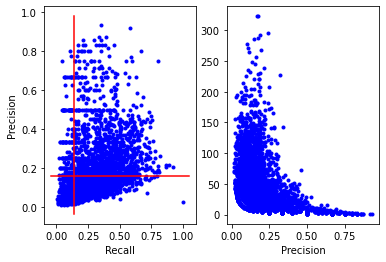

In [116]:
plotit(genecounts)

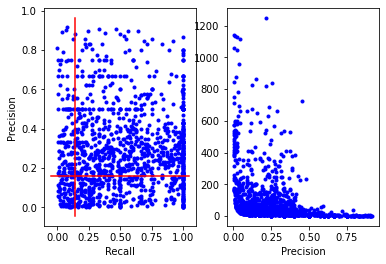

In [117]:
plotit(diseasecounts)

In [91]:
diseasecounts[diseasecounts[False] > 1000]

,False,True,gene_count,Precision,Recall
disease,,,,,
MONDO:0001071,1246.0,347.0,609,0.217828,0.569787
MONDO:0001170,1134.0,10.0,17,0.008741,0.588235
MONDO:0001220,1125.0,26.0,35,0.022589,0.742857
MONDO:0001442,1061.0,3.0,13,0.002820,0.230769
MONDO:0005395,1115.0,48.0,66,0.041273,0.727273
MONDO:0006816,1047.0,28.0,43,0.026047,0.651163
MONDO:0019056,1140.0,2.0,2,0.001751,1.000000


This query is a triangle (containng the gene) and one of the other points of the triangle branches to the disease. The link is (triangle_disease)-[has phenotpye]->(input disease). The answers with the most False hits, and therefore worst precision are those where the number of triangle diseases for the input disease is very large (like 1000).

In [98]:
geneprecision = genecounts['Precision'].values
geneprecision.sort()
diseaseprecision = diseasecounts['Precision'].values
diseaseprecision.sort()

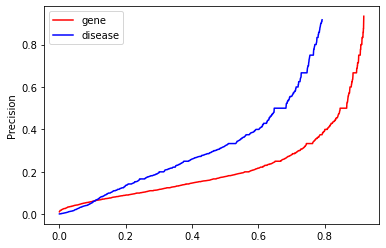

In [108]:
plt.plot(np.linspace(0,1,num=len(geneprecision)),geneprecision,'r-',label='gene')
plt.plot(np.linspace(0,1,num=len(diseaseprecision)),diseaseprecision,'b-',label='disease')
plt.legend()
plt.ylabel('Precision')
plt.show()

In [104]:
generecall = genecounts['Recall'].values
generecall.sort()
diseaserecall = diseasecounts['Recall'].values
diseaserecall.sort()

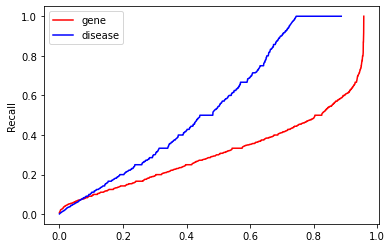

In [110]:
plt.plot(np.linspace(0,1,num=len(generecall)),generecall,'r-',label='gene')
plt.plot(np.linspace(0,1,num=len(diseaserecall)),diseaserecall,'b-',label='disease')
plt.legend()
plt.ylabel('Recall')
plt.show()

In [186]:
hf = pd.read_csv('hemiplegia_p0.csv')
genes = set(hf['n3: Gene'].values)
names = pd.Series({ x:x.split()[0] for x in genes}).reset_index()
names.rename({'index':'n3: Gene',0:'gene'},inplace=True,axis=1)
hf = pd.merge(hf,names,on='n3: Gene')
hf.head()

,row,n0: Biological Entity,n1: Disease,n2: Phenotypic Feature,n3: Gene,score,gene
0,1,hemiplegia (MONDO:0001170),amyotrophic lateral sclerosis (MONDO:0004976),Spasticity (HP:0001257),SOD1 (NCBIGene:6647),0.174841,SOD1
1,3,hemiplegia (MONDO:0001170),amyotrophic lateral sclerosis (MONDO:0004976),Neck muscle weakness (HP:0000467),SOD1 (NCBIGene:6647),0.145639,SOD1
2,5,hemiplegia (MONDO:0001170),amyotrophic lateral sclerosis (MONDO:0004976),Waddling gait (HP:0002515),SOD1 (NCBIGene:6647),0.138170,SOD1
3,7,hemiplegia (MONDO:0001170),amyotrophic lateral sclerosis (MONDO:0004976),Chronic fatigue (HP:0012432),SOD1 (NCBIGene:6647),0.126877,SOD1
4,9,hemiplegia (MONDO:0001170),amyotrophic lateral sclerosis (MONDO:0004976),Dyspnea (HP:0002094),SOD1 (NCBIGene:6647),0.123824,SOD1


In [189]:
x = pd.DataFrame({'score':hf.groupby('gene').max()['score']}).reset_index()
x.sort_values(by='score',ascending=False,inplace=True)
x.head()

,gene,score
959,SOD1,0.174841
359,FUS,0.148309
876,SCN1A,0.139404
1004,TARDBP,0.130857
384,GFAP,0.124225


In [190]:
trues = ['AKT3', 'ATP1A2', 'ATP1A3', 'CACNA1A' ,'GK', 'NR0B1','PLG','SCN1A','SIX3','SLC2A1']
truedat = pd.DataFrame({'gene':trues, 'hit':1})

In [196]:
merged_df = pd.merge(x,truedat,on='gene',how='left')

In [204]:
scores = merged_df['score']
hits = [1 if x==1.0 else 0 for x in merged_df['hit'] ]

In [208]:
cumhits = [ sum(hits[:x]) for x in range(len(hits))]

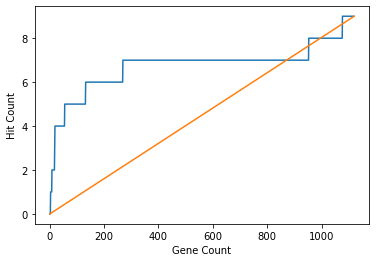

In [215]:
plt.plot(range(len(cumhits)),cumhits)
plt.plot([0,len(cumhits)],[0,max(cumhits)])
plt.xlabel('Gene Count')
plt.ylabel('Hit Count')
plt.show()